### Run Incidents Model

- Here we present a demo of running inference with our model, from a checkpoint.
- To train a model for yourself, please see the `README.md` with instructions for using `run_model.py`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pprint
import json
from tqdm import tqdm
import cv2
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from architectures import (
    FilenameDataset,
    get_incidents_model,
    update_incidents_model_with_checkpoint,
    update_incidents_model_to_eval_mode,
    get_predictions_from_model
)
from parser import get_parser, get_postprocessed_args

In [3]:
# data
IMAGES_PATH = "/data/vision/torralba/humanitarian/datasets/images_raw/"
DATASET_FILENAME = "data/eccv_test.json"

# model
CONFIG_FILENAME = "configs/eccv_final_model"
CHECKPOINT_PATH_FOLDER = "pretrained_weights/"

In [4]:
with open(DATASET_FILENAME, "r") as fp:
    dataset = json.load(fp)

In [5]:
image_filenames = [os.path.join(IMAGES_PATH, image_name) for image_name in list(dataset.keys())[:4]]

In [6]:
image_filenames

['/data/vision/torralba/humanitarian/datasets/images_raw/under_construction_museum_outdoor/7087c8e50e.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/building_facade_with_smoke/cd10d93369.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/boat_accident_in_fire_station/b84f319c7d.jpg',
 '/data/vision/torralba/humanitarian/datasets/images_raw/wild_fire_in_ocean/00261.jpg']

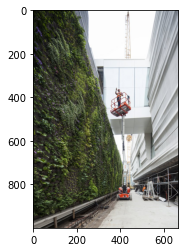

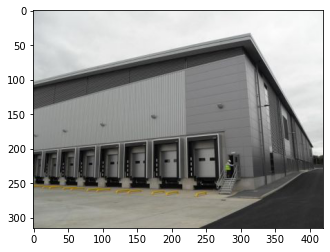

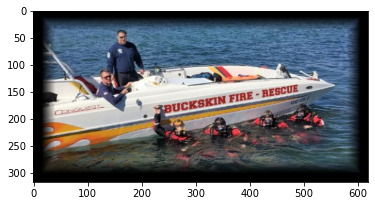

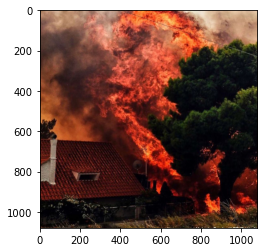

In [7]:
for image_filename in image_filenames:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()

In [8]:
# Load model from checkpoint.
parser = get_parser()
args = parser.parse_args(args="--config={} --checkpoint_path={} --mode=test --num_gpus=1".format(CONFIG_FILENAME, CHECKPOINT_PATH_FOLDER))
args = get_postprocessed_args(args)

incidents_model = get_incidents_model(args)
update_incidents_model_with_checkpoint(incidents_model, args)
update_incidents_model_to_eval_mode(incidents_model)

loading places weights for pretraining
Let's use 4 GPUs!
eccv_final_model
Loaded checkpoint 'pretrained_weights/eccv_final_model_trunk.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_place.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_incident.pth.tar' (epoch 15).
Switching to eval mode.


In [9]:
from utils import get_index_to_incident_mapping, get_index_to_place_mapping

In [10]:
# Set up the data loader for quickly loading images to run inference with.
print("num images: {}".format(len(image_filenames)))
targets = [image_filenames[i] for i in range(len(image_filenames))]
dataset = FilenameDataset(image_filenames, targets)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

inference_dict = {}
for idx, (batch_input, image_paths) in tqdm(enumerate(loader)):
    # run the model, get the output, set the inference_dict
    output = get_predictions_from_model(
        args,
        incidents_model,
        batch_input,
        image_paths,
        get_index_to_incident_mapping(),
        get_index_to_place_mapping(),
        inference_dict,
        topk=5
    )

num images: 4


4it [00:00,  4.59it/s]


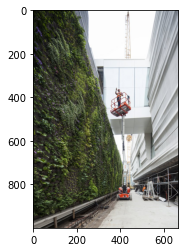

{'incident_probs': array([0.3466558 , 0.0217282 , 0.01689646, 0.01217993, 0.01166387],
      dtype=float32),
 'incidents': ['under construction',
               'blocked',
               'flooded',
               'earthquake',
               'heavy rainfall'],
 'place_probs': array([0.34856418, 0.26513055, 0.09828012, 0.04043418, 0.03864238],
      dtype=float32),
 'places': ['street',
            'building outdoor',
            'highway',
            'downtown',
            'building facade']}


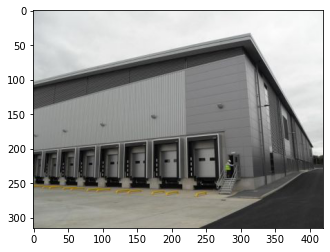

{'incident_probs': array([0.01821717, 0.01333643, 0.0117256 , 0.00502099, 0.00421425],
      dtype=float32),
 'incidents': ['derecho', 'under construction', 'fog', 'damaged', 'drought'],
 'place_probs': array([0.13505751, 0.09579939, 0.06402247, 0.0628997 , 0.05473058],
      dtype=float32),
 'places': ['industrial area',
            'gas station',
            'building outdoor',
            'fire station',
            'building facade']}


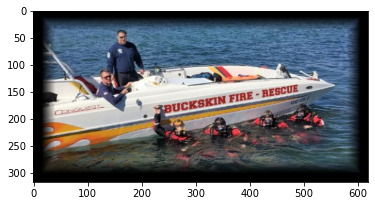

{'incident_probs': array([2.9926407e-01, 7.7600492e-04, 6.3818123e-05, 3.8240782e-05,
       2.2685133e-05], dtype=float32),
 'incidents': ['ship boat accident',
               'airplane accident',
               'oil spill',
               'bus accident',
               'on fire'],
 'place_probs': array([0.25601006, 0.16030513, 0.0981757 , 0.07478   , 0.07306472],
      dtype=float32),
 'places': ['river', 'coast', 'lake natural', 'port', 'ocean']}


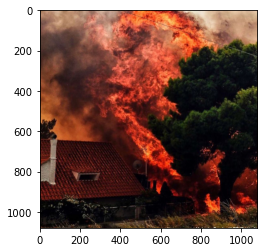

{'incident_probs': array([0.7823977 , 0.07579279, 0.05682516, 0.00931623, 0.00642855],
      dtype=float32),
 'incidents': ['wildfire',
               'fire whirl',
               'on fire',
               'nuclear explosion',
               'volcanic eruption'],
 'place_probs': array([0.3168282 , 0.12410558, 0.06958483, 0.04549508, 0.03944487],
      dtype=float32),
 'places': ['house', 'building outdoor', 'farm', 'forest', 'volcano']}


In [11]:
for image_filename in inference_dict:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()
    pprint.pprint(inference_dict[image_filename])